# CS8321 Lab 3: CNN Visualization
#### Authors: Bryce Shurts, Michael Amberg, Wali Chaudhary


*Explain the model you chose and why.*
First and foremost, we have decided to go with VGG19, which is a 19-layer deep CNN that, in our case, has been
pre-trained on ImageNet12. This network supports classification of 1000 different object classes that span a variety of domains (animals, objects, etc.) and functions by analyzing 224x224 images in a 3-channel RGB layout.
 As for why we chose it, there are several reasons: chiefly it is a fairly simple network without branching layers, which greatly simplifies our analysis process when looking at multi-layer filters. Additionally, it is a popular and well-supported model, allowing us to load a pre-trained version directly from PyTorch's model library. It is also one of the models provided within OpenAI's Microscope, meaning we do not have to write extra code to do some of our initial analysis on which conv layer & layer unit that we would like to explore further. Furthermore, the model is used by Dr. Larson in his example code, which provides us with a stronger basis for reference than if we had gone with a different model that uses a different architecture (at least in terms of layer-layout). Finally, the model itself is not particularly large, which enables members of our team who do not have access to CUDA-accelerated GPUS to still inference the model at an acceptable speed.

*Classify a few images with pre-trained network to verify that it is working properly.* See below:

In [1]:
from typing import List
import torch
from torch import device
import torchvision
import cv2
import numpy as np
from matplotlib import pyplot as plt

from torch import optim



from functools import wraps


# UNCOMMENT BELOW IF NOT USING PYCHARM/DATASPELL IN DARK MODE
# from matplotlib.pyplot import imshow

if not torch.cuda.is_available():
    print("Warning: Using CPU for Pytorch.")
device: device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
IMAGE_DIM: int = 224
MEAN: List[float] = [0.485, 0.456, 0.406]
STD: List[float] = [0.229, 0.224, 0.225]
LABELS: str = "ilsvrc2012_wordnet_lemmas.txt"

C:\Users\michael.amberg\AppData\Local\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataspell dark mode image inversion work-around
# Because I don't want to have to change my entire IDE for a single project
from functools import wraps

@wraps(plt.imshow)
def imshow(*args, **kwargs):
    plt.style.use('dark_background')
    output = plt.imshow(*args, **kwargs)
    plt.style.use('default')

    return output

In [3]:
# Function provided courtesy of pyimagesearch.com
def preprocess_image(image: np.ndarray) -> np.ndarray:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Swap from OpenCV-default BGR to RGB color channel ordering
    image = cv2.resize(image, (IMAGE_DIM, IMAGE_DIM)) # Resize image in 224x224 as expected by ImageNet-trained VGG19
    image = image.astype("float32")/255 # Covert image into floating point data and scale intensities between 0 and 1
    image -= MEAN # CNN normalization pixel intensities for ImageNet
    image /= STD # CNN normalization of pixel intensities for ImageNet
    image = np.transpose(image, (2, 0, 1)) # Swap to channel-first ordering
    image = np.expand_dims(image, 0) # Add batching dimension
    return image

In [4]:
model = torchvision.models.vgg19(pretrained=True).to(device) # pretrained on ImageNet2012
model.eval()
def classify_image(image_path: str) -> None:
    img = cv2.imread(image_path)
    processed_img = torch.from_numpy(preprocess_image(img)).to(device)
    label_dict = dict(enumerate(open(LABELS)))

    probs = torch.nn.Softmax(dim=-1)(model(processed_img))
    sorted_probs = torch.argsort(probs, dim=-1, descending=True)

    imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    for (idx, image_class) in enumerate(sorted_probs[0, :5]):
        print("{}. {}: {:.2f}%".format(idx, label_dict[image_class.item()].strip(), probs[0, image_class.item()] * 100))

C:\Users\michael.amberg\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\michael.amberg\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


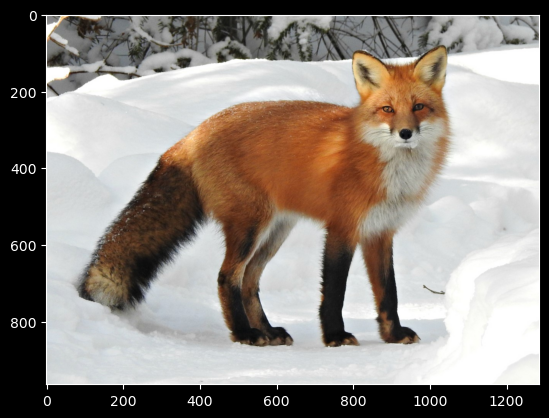

0. red_fox, Vulpes_vulpes: 86.68%
1. grey_fox, gray_fox, Urocyon_cinereoargenteus: 9.69%
2. kit_fox, Vulpes_macrotis: 2.67%
3. coyote, prairie_wolf, brush_wolf, Canis_latrans: 0.56%
4. Arctic_fox, white_fox, Alopex_lagopus: 0.32%
------------


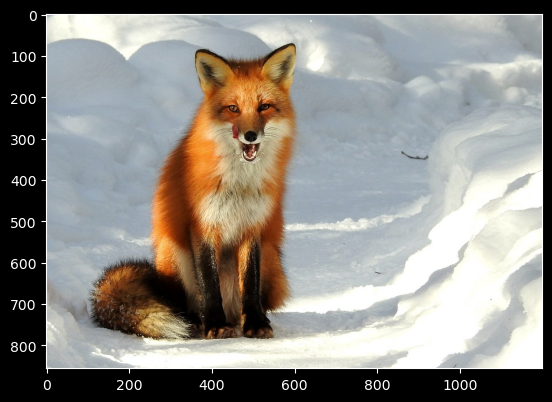

0. red_fox, Vulpes_vulpes: 95.98%
1. kit_fox, Vulpes_macrotis: 2.36%
2. grey_fox, gray_fox, Urocyon_cinereoargenteus: 1.65%
3. coyote, prairie_wolf, brush_wolf, Canis_latrans: 0.01%
4. Arctic_fox, white_fox, Alopex_lagopus: 0.00%
------------


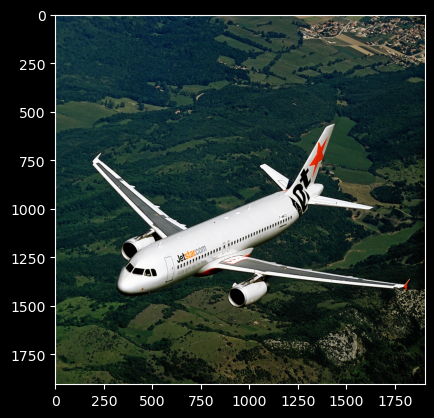

0. airliner: 59.43%
1. space_shuttle: 33.23%
2. wing: 6.40%
3. missile: 0.52%
4. projectile, missile: 0.13%
------------


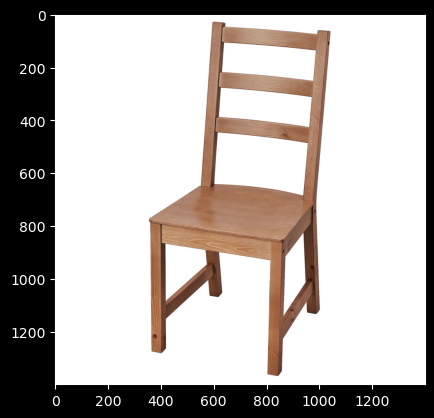

0. rocking_chair, rocker: 50.48%
1. folding_chair: 45.23%
2. guillotine: 1.94%
3. dining_table, board: 0.24%
4. throne: 0.23%


In [6]:
classify_image("pictures/its_a_fox.jpg")
print("------------")
classify_image("pictures/fox_2.jpg")
print("------------")
classify_image("pictures/nyoom.jpg")
print("------------")
classify_image("pictures/just_a_chair.jpg")


Surprisingly a full side profile of a fox had a lower classification percentage than a front-on that comparatively gives less overall information about the animal. 


For part 2: I'm thinking we can use https://microscope.openai.com/models/vgg19_caffe/conv5_4_conv5_4_0/443 since it will
likely respond well to foxes (namely their faces) and other fox-colored red/white two-toned animals (like red pandas)

Why foxes? The very scientific reason of it was the first animal I thought of (and also there are a billion features for
dogs which makes picking one difficult - that conv layer also had a good one for felines in general in the 200-300 range
but i forget the specific layer)

There might be other layers that are also excited by this but the spatial bias mapping looks like a strong contender for
Vulpes and Vulpes-like animals. It certainly seems to be extracting a combination of coloring (red on top, white on
bottom) + structure (muzzled face, lots of fur but canine shape vs a flatter feline profile)

In [22]:
def maximize_activation(model, layer_name: str, unit: int, iterations: int = 30, lr: float = 0.2, image_path: str = "none"):
    # Hook for extracting specific layer's output
    activation = {}
    def hook_function(module, input, output):
        activation[layer_name] = output

    # Register hook to the selected layer
    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_function)
    
    image = torch.randn(1, 3, IMAGE_DIM, IMAGE_DIM, device=device, requires_grad=True)
    if image_path != "none":
        e_image = cv2.imread(image_path)
        image = torch.from_numpy(preprocess_image(e_image)).to(device)
    
    image.requires_grad = True

    # Capture pre-optimization activation
    model(image)
    pre_activation = activation[layer_name][0, unit].mean().item()
    activation[layer_name] = None  # Clear activation to avoid mixing pre and post optimization activations

    # Optimization
    optimizer = optim.Adam([image], lr=lr, weight_decay=1e-6)
    
    for i in range(iterations):
        optimizer.zero_grad()
        model(image)
        loss = -activation[layer_name][0, unit].mean()
        loss.backward()
        optimizer.step()

    hook.remove()  # Remove the hook after optimization
    
    # Capture post-optimization activation
    model(image)
    post_activation = activation[layer_name][0, unit].mean().item()
    
    img = cv2.imread(image_path)
    imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Pre-Activation: {pre_activation:.4f}")
    plt.show()
    
    optimized_image = image.detach().cpu().squeeze().numpy()
    optimized_image = np.transpose(optimized_image, (1, 2, 0))  # to HWC
    optimized_image = np.clip(optimized_image, 0, 1)
    imshow(optimized_image)
    plt.title(f"Post-Activation: {post_activation:.4f}")
    plt.show()



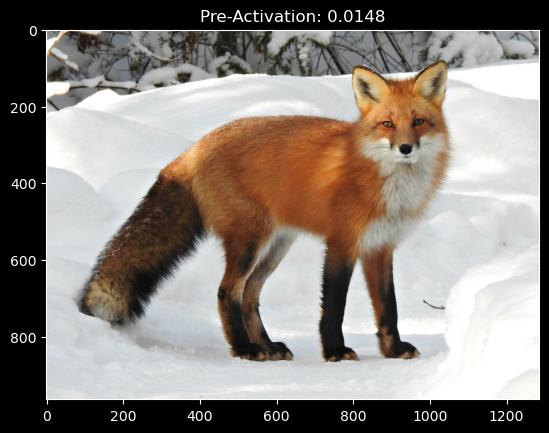

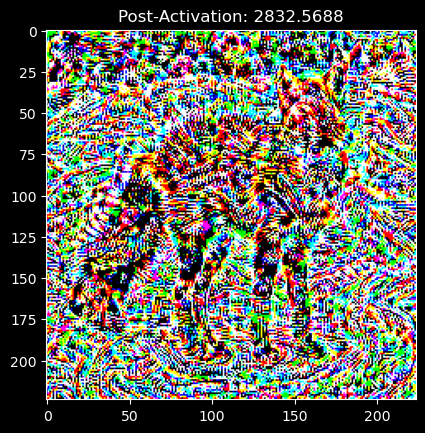

------------


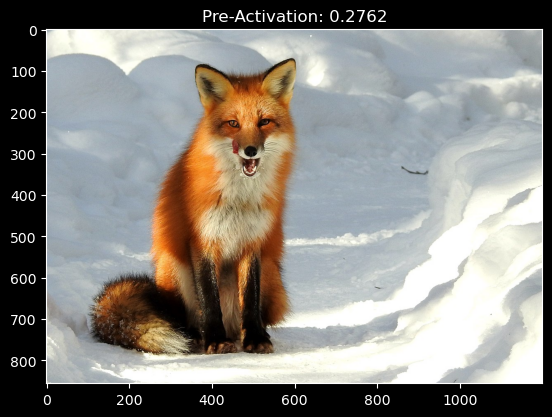

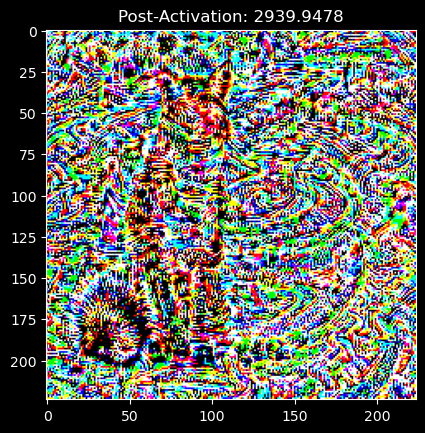

------------


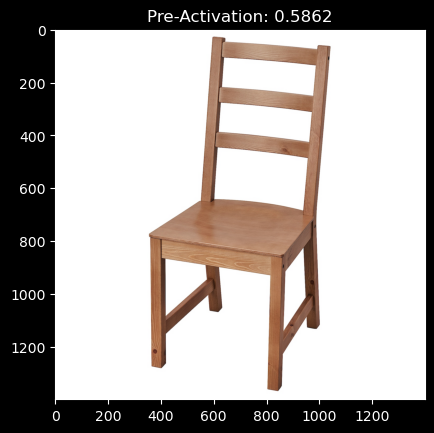

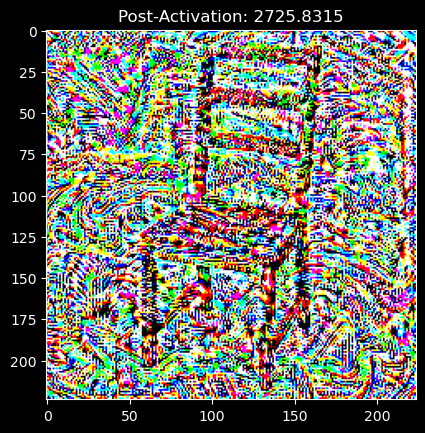

------------


In [24]:
maximize_activation(model, 'features.35', unit=443, iterations=100,image_path="pictures/its_a_fox.jpg")
print("------------")
maximize_activation(model, 'features.35', unit=443, iterations=100,image_path="pictures/fox_2.jpg")
print("------------")
maximize_activation(model, 'features.35', unit=443, iterations=100,image_path="pictures/just_a_chair.jpg")
print("------------")